## Goal

With this project I will try to train a neural network to predict whether the stock market closing index S&P 500 will rise or fall on a particular date, based on most recent previous values and other stock markets around the world (where some markets close earlier that day because of time difference).

- All Ords (Australlia), closing EST= 01am
- Nikkei 225 (Japan), closing EST= 02am
- Hang Seng (Hong Kong), closing EST= 04am
- DAX (Germany), closing EST= 11:30am
- NYSE Composite (US), closing EST= 04pm
- Dow Jones Industrial Average (US), closing EST= 04pm
- S&P 500 (US), closing EST= 04pm

We can use closing price of All Ords, Nikkei 225, Hang Seng and DAX to predict closing price of S&P 500 on the same day, since they close earlier.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import date
from nsepy import get_history
import matplotlib.pyplot as plt
%matplotlib inline
import functools
import math
from sklearn import preprocessing as pp

# Step 1: Prepare data

In [2]:
data = get_history(symbol="NIFTY", start=date(2017,1,1), end=date(2019,5,17), index = True)

## III. Clean data

In [3]:
print(data.head())

               Open     High      Low    Close     Volume      Turnover
Date                                                                   
2017-01-02  8210.10  8212.00  8133.80  8179.50  122016111  5.255490e+10
2017-01-03  8196.05  8219.10  8148.60  8192.25  131186021  6.053670e+10
2017-01-04  8202.65  8218.50  8180.90  8190.50  136476345  6.543130e+10
2017-01-05  8226.65  8282.65  8223.70  8273.80  163957452  8.180680e+10
2017-01-06  8281.85  8306.85  8233.25  8243.80  143689850  7.298740e+10


In [4]:
data.describe()

,Open,High,Low,Close,Volume,Turnover
count,587.000000,587.000000,587.000000,587.000000,5.870000e+02,5.870000e+02
mean,10333.968569,10371.572743,10279.540290,10326.231687,2.570281e+08,1.309764e+11
std,811.725487,815.555543,801.815012,808.183431,9.588361e+07,4.388493e+10
min,8196.050000,8212.000000,8133.800000,8179.500000,3.108638e+07,1.534080e+10
25%,9882.775000,9904.500000,9834.525000,9872.950000,1.906996e+08,9.881730e+10
50%,10464.850000,10503.600000,10412.550000,10458.350000,2.334096e+08,1.226766e+11
75%,10851.125000,10891.300000,10786.100000,10833.400000,3.047829e+08,1.542600e+11
max,11856.150000,11856.150000,11738.500000,11787.150000,7.411532e+08,3.513119e+11


In [5]:
data.dtypes

Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Turnover    float64
dtype: object

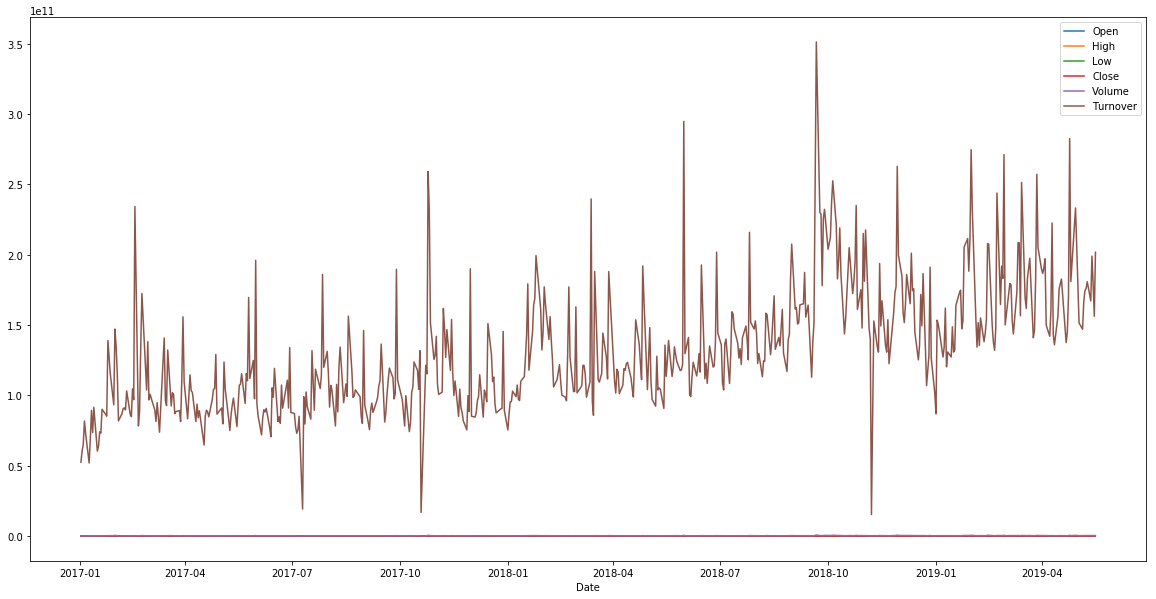

In [6]:
# observe data in graph
data.plot(figsize=(20,10))

In [7]:
def sum_bp_n(data,n,i): #calculates the sum of Buying Pressure over the last 7 days
    arr = []
    for j in range(0,n):
        bp = data.Close[i-j] - min(data.Low[i-j],data.Close[i-j-1])
        arr.append(bp)
    return sum(arr)

In [8]:
def sum_tr_n(data,n,i): #calculates the sum of True Range over the last 7 days
    arr = []
    for j in range(0,n):
        tr = max(data.High[i-j],data.Close[i-j-1]) - min(data.Low[i-j],data.Close[i-j-1])
        arr.append(tr)
    return sum(arr)

In [9]:
def ult_Oscill(data):
    n = len(data)
    arr = []
    
    for i in range(0,27):
        arr.append('N')
    
    for i in range(27,n):
        
        bp_7 = sum_bp_n(data,7,i)
        bp_14 = sum_bp_n(data,14,i)
        bp_28 = sum_bp_n(data,28,i)

        tr_7 = sum_tr_n(data,7,i)
        tr_14 = sum_tr_n(data,14,i)
        tr_28 = sum_tr_n(data,28,i)
        
        av_7 = bp_7/tr_7
        av_14 = bp_14/tr_14
        av_28 = bp_28/tr_28
        
        uo = ( (av_7)*4 + (av_14)*2 + (av_28)*1 )*100/(4+2+1)
        
        arr.append(uo)
    return arr

uo = ult_Oscill(data)
print(len(uo))
data['UO'] = uo

587


In [10]:
def n_per_High_Close(data,n,i): #Highest closing price in previous n days
    arr = []
    for j in range(0,n):
        close = data.Close[i-j]
        arr.append(close)
    return max(arr)

In [11]:
def n_per_Sum_pdd(data,n,i): #n period sum of Percentage Drawdown
    arr = []
    for j in range(0,n):
        HCls_14 = n_per_High_Close(data,14,i)
        pdd = (data.Close[i-j] - HCls_14)*100/HCls_14 #Percentage Drawdown
        arr.append(pdd)
    return sum(arr)

In [12]:
def ulc_Index(data):
    n = len(data)
    arr = []
    
    for i in range(0,14):
        arr.append('N')
    
    for i in range(14,n):
        sq_av = n_per_Sum_pdd(data,14,i)/14
        ui = math.sqrt(abs(sq_av))
        arr.append(ui)
    return arr

ui = ulc_Index(data)
#print(len(ui))
data['UI'] = ui

In [13]:
def n_per_SMA(arr,n): 
    sum = 0
    l = len(arr)
    for j in range(0,n):
        sum = sum + arr[l-j-1]
    return (sum/n)

In [14]:
def n_per_ROC(arr,n,i):
    arr1 = []
    for j in range(0,n):
        roc = (arr[i-j]-arr[i-j-n])*100/n
        arr1.append(roc) 
    return arr1

In [15]:
def KST(data): #Pring's Know Sure Thing
    arr = []
    n = len(data)
    for i in range(0,30):
        arr.append('N')
    for i in range(30,n):
        RCMA_1 = n_per_SMA(n_per_ROC(data.Close.tolist(),10,i),10)
        RCMA_2 = n_per_SMA(n_per_ROC(data.Close.tolist(),15,i),10)
        RCMA_3 = n_per_SMA(n_per_ROC(data.Close.tolist(),20,i),10)
        RCMA_4 = n_per_SMA(n_per_ROC(data.Close.tolist(),30,i),15)
        kst = 1*RCMA_1 + 2*RCMA_2 + 3*RCMA_3 + 4*RCMA_4
        arr.append(kst)
    return arr

arr = KST(data)
data['KST'] = arr 

In [16]:
def RVI(data): #incomplete
    n = len(data)
    for i in range(3,n):
        a = data.Close[i] - data.Open[i]
        b = data.Close[i-1] - data.Open[i-1]
        c = data.Close[i-2] - data.Open[i-2]
        d = data.Close[i-3] - data.Open[i-3]
        
        e = data.High[i] - data.Low[i]
        f = data.High[i-1] - data.Low[i-1]
        g = data.High[i-2] - data.Low[i-2]
        h = data.High[i-3] - data.Low[i-3]

In [17]:
def PVI(data): #Positive Volume Index
    pvi = data.Volume[0] #I'm assuming the base case is the volume on the first day for which data is available. 
    arr = []
    arr.append('N')
    n = len(data)
    for i in range(1,n):
        if data.Volume[i] > data.Volume[i-1]:
            pvi = pvi + ((data.Close[i]-data.Close[i-1])/data.Close[i-1])*pvi
        arr.append(pvi)
    return arr

arr = PVI(data)
data['PVI'] = arr

In [18]:
def NVI(data): #Positive Volume Index
    nvi = data.Volume[0] #I'm assuming the base case is the volume on the first day for which data is available. 
    arr = []
    arr.append('N')
    n = len(data)
    for i in range(1,n):
        if data.Volume[i] < data.Volume[i-1]:
            nvi = nvi + ((data.Close[i]-data.Close[i-1])/data.Close[i-1])*nvi
        arr.append(nvi)
    return arr

arr = NVI(data)
data['NVI'] = arr

In [19]:
def MFI(data): #Market Facilitation Index
    arr = []
    n = len(data)
    for i in range(0,n):
        mfi = (data.High[i]-data.Low[i])/data.Volume[i]
        arr.append(mfi)
    return arr

arr = MFI(data)
data['MFI'] = arr

In [20]:
def sum_gains_losses(data,n,i):
    g = []
    l = []
    for j in range(0,n):
        if data.Close[i-j]>data.Close[i-j-1]:
            g.append(data.Close[i-j]-data.Close[i-j-1])
        else:
            l.append(data.Close[i-j-1]-data.Close[i-j])
    sum_gains = sum(g)
    sum_losses = sum(l)
    return sum_gains,sum_losses 

In [21]:
def IMI(data):
    n = len(data)
    arr = []
    for i in range(0,14):
        arr.append('N')
    for i in range(14,n):
        s_g,s_l = sum_gains_losses(data,14,i) #Change the 14 to X to change period (3 times)
        imi = (s_g)/(s_g+s_l)
        arr.append(imi)
    return arr

arr = IMI(data)
data['IMI'] = arr

In [22]:
def EFI(data): #Elder's Force Index
    arr = []
    arr.append('N')
    n = len(data)
    for i in range(1,n):
        efi = (data.Close[i]-data.Close[i-1])*data.Volume[i]
        arr.append(efi)
    return arr
arr = EFI(data)
data['EFI'] = arr

In [23]:
def n_per_SMA(arr,n,i): 
    sum = 0
    for j in range(0,n):
        sum = sum + arr[i-j-1]
    return (sum/n)

In [24]:
def DPO(data): #Detrended Price Oscillator
    l = 14 #Lookback Period
    n = len(data)
    arr = []
    for i in range(0,l):
        arr.append('N')
    for i in range(l,n):
        sma = n_per_SMA(data.Close,l,i)
        dpo = data.Close[i-((l//2)+1)] - sma
        arr.append(dpo)
    return arr

arr = DPO(data)
data['DPO'] = arr

In [25]:
def TR(data,i):
    a = data.High[i] - data.Low[i]
    b = abs(data.High[i] - data.Close[i-1])
    c = abs(data.Low[i] - data.Close[i-1])    
    tr = max(a,b,c)
    return tr

In [26]:
def n_per_sum_TR(data,n,i): #Calculates the sum of the TR for the past n periods
    arr = []
    for j in range(0,n):
        arr.append(TR(data,i-j))
    return sum(arr)

In [27]:
def n_per_ATR(data,n):
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        sum = n_per_sum_TR(data,n,i)
        atr = sum/n
        arr.append(atr)
    return arr

In [28]:
arr = n_per_ATR(data,14)
data['ATR_14'] = arr

In [29]:
def n_per_CMO(data,n): #Chande Momentum Oscillator
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        hc = [] #High Closes in the last n periods. A high close is the close when the closing price is greater than opening price
        lc = [] #Low Closes in the last n periods
        for j in range(0,n):
            if data.Close[i-j]>data.Open[i-j]:
                hc.append(data.Close[i-j])
            else:
                lc.append(data.Close[i-j])
        sH = sum(hc)
        sL = sum(lc)
        cmo = ( (sH-sL)/(sH+sL) )*100
        arr.append(cmo)
    return arr

arr = n_per_CMO(data,14) #Taking N = 14 for now
data['CMO'] = arr

In [30]:
def pers_since_n_per_High_Close(data,n,i): #Periods (days) since highest closing price in previous n days
    arr = []
    for j in range(0,n):
        close = data.Close[i-j]
        arr.append(close)
    for j in range(0,n):
        if float(arr[j]) == max(arr):
            return n-j

In [31]:
def pers_since_n_per_Low_Close(data,n,i): #Periods (days) since lowest closing price in previous n days
    arr = []
    for j in range(0,n):
        close = data.Close[i-j]
        arr.append(close)
    for j in range(0,n):
        if float(arr[j]) == min(arr):
            return n-j

In [32]:
def n_per_AO_up(data,n): #n period Aroon Oscillator
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        p_h = pers_since_n_per_High_Close(data,n,i)
        a_up = 100*(n - p_h)/n
        arr.append(a_up)
    return arr

In [33]:
def n_per_AO_down(data,n): #n period Aroon Oscillator
    arr = []
    for i in range(0,n):
        arr.append('N')
    for i in range(n,len(data)):
        p_l = pers_since_n_per_Low_Close(data,n,i)
        a_down = 100*(n - p_l)/n
        arr.append(a_down)
    return arr

In [34]:
aroon_up = n_per_AO_up(data,25)
aroon_down = n_per_AO_down(data,25)

data['AO_up'] = aroon_up
data['AO_down'] = aroon_down

In [35]:
def transform(arr): #transforms the elements of the input array to values between -1 and 1
    for i in range(0,len(arr)):
        arr[i] = 2*((arr[i]-min(arr))/(max(arr)-min(arr))) - 1
        if float(arr[i]) == 1.0:
            arr[i] = 0.9999
        elif float(arr[i]) == -1.0:
            arr[i] = -0.9999
    return arr

In [36]:
def n_per_FT(arr,n): #Fisher Transform
    arr1 = []
    for i in range(0,n):
        arr1.append('N')
    for i in range(n,len(arr)):
        ft = 0.5*(math.log(abs((1+arr[i])/(1-arr[i]))))
        arr1.append(ft)
    return arr1

In [37]:
arr = n_per_FT(transform(data.Close),14)
data['FT'] = arr

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [38]:
def WC(data): #Weighted Close 
    arr = []
    n = len(data)
    for i in range(0,n):
        wc = (data.High[i]+data.Low[i]+2*data.Close[i])/4
        arr.append(wc)
    return arr

arr = WC(data)
data['WC'] = arr

In [39]:
def n_per_McD(data,n): #McGinley Dynamic #n is the number of periods over which you want smoothening
    arr = []
    arr.append(0) #Specify base case here (I have arbitrarily taken it as zero)
    for i in range(1,len(data)):
        c = (data.Close[i]/arr[i-1])**4
        md = arr[i-1] + ((data.Close[i]-arr[i-1])/(0.6*n*c))
        arr.append(md)
    return arr

arr = n_per_McD(data,20) #Change length by changing this 20
data['MD_20'] = arr 

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [40]:
# 5-day momentum
def momentum(df):
    n = len(df)
    arr = []
    for i in range(0,5):
        arr.append('N')
    for j in range(5,n):
        momentum = df.Close[j] - df.Close[j-5] #Equation for momentum
        arr.append(momentum)
    return arr

momentum = momentum(data)
data['Momentum'] = momentum

In [41]:
data_pctchange=data.Close.pct_change()
data['Return'] = data_pctchange

In [42]:
def ROI(df,n):
    m = len(df)
    arr = []
    for i in range(0,n):
        arr.append('N')
    for j in range(n,m):
        roi= (df.Close[j] - df.Close[j-n])/df.Close[j-n] #Equation for ROI
        arr.append(roi)
    return arr
ROI10=ROI(data,10)
ROI20=ROI(data,20)
ROI30=ROI(data,30)
data['10 Day ROI']=ROI10
data['20 Day ROI']=ROI20
data['30 Day ROI']=ROI30

In [43]:
def RSI(df,period):
    # get average of upwards of last 14 days: Ct - Ct-1
    # get average of downwards of last 14 days: Ct-1 - Ct
    n = len(df)
    arr = []
    for i in range(0,period):
        arr.append('N')
    for j in range(period,n):
        total_upwards = 0
        total_downwards = 0
        # this will find average of upwards
        for k in range(j,j-period,-1):
            if(df.Close[k-1] > df.Close[k]):
                total_downwards = total_downwards + (df.Close[k-1] - df.Close[k])    
        avg_down = total_downwards / period
        for l in range(j,j-period,-1):
            if(df.Close[l] > df.Close[l-1]):
                total_upwards = total_upwards + (df.Close[l] - df.Close[l-1])
        avg_up = total_upwards / period
        RS = avg_up / avg_down
        RSI  = 100 - (100/(1+RS))
        arr.append(RSI)
    return arr

RSI_17 = RSI(data,17)
RSI_14 = RSI(data,14)
RSI_10 = RSI(data,10)
RSI_30 = RSI(data,30)
data['17_day_RSI'] = RSI_17
data['10_day_RSI'] = RSI_10
data['14_day_RSI'] = RSI_14
data['30_day_RSI'] = RSI_30

In [44]:
def EMA(df, n):
    m = len(df)
    arr = []
    arr.append('N')
    prevEMA = df.Close[0]
    for i in range(1,m):
        close = df.Close[i]
        EMA = ((2/(n+1))*close) + ((1-(2/(n+1)))*prevEMA)
        arr.append(EMA)
        prevEMA = EMA
    return arr
EMA_12 = EMA(data, 12)
EMA_26 = EMA(data, 26)
data['EMA_12'] = EMA_12
data['EMA_26'] = EMA_26

In [45]:
#MACD
# Moving Average of EMA(n) - EMA(m2) for each row
# where n = 12 and m2 = 26
def MACD(df):
    n = 12
    m2 = 26
    arr = []
    arr.append('N')
    ema_12 = EMA(df,n)
    ema_26 = EMA(df,m2)
    m = len(df)
    for i in range(1,m):
        arr.append(ema_12[i] - ema_26[i])
    return arr


MACD = MACD(data)
data['MACD'] = MACD

In [46]:
#SRSI: Stochastic RSI
#SRSI = (RSI_today - min(RSI_past_n)) / (max(RSI_past_n) - min(RSI_past_n))
def SRSI(df,n):
    m = len(df)
    arr = []
    list_RSI = RSI(df,n)
    for i in range(0,n):
        arr.append('N')
    for j in range(n,n+n):
        last_n = list_RSI[n:j]
        if(not(last_n == []) and not(max(last_n) == min(last_n))):
            SRSI = (list_RSI[j] - min(last_n)) / (max(last_n)- min(last_n))
            if SRSI > 1:
                arr.append(1)
            else:
                arr.append(SRSI)
        else:
            arr.append(0)
    for j in range(n+n,m):
        last_n = list_RSI[2*n:j]
        if(not(last_n == []) and not(max(last_n) == min(last_n))):
            SRSI = (list_RSI[j] - min(last_n)) / (max(last_n)- min(last_n))
            if SRSI > 1:
                arr.append(1)
            else:
                arr.append(SRSI)
        else:
            arr.append(0)
    return arr

SRSI_10 = SRSI(data,10)
SRSI_14 = SRSI(data,14)
SRSI_30 = SRSI(data,30)
SRSI_17 = SRSI(data,17)

data['SRSI_17'] = SRSI_17
data['SRSI_10'] = SRSI_10
data['SRSI_14'] = SRSI_14
data['SRSI_30'] = SRSI_30

In [47]:
def Williams(df,n): #Williams %R oscillator for each day
    m = len(df)
    arr = []
    for i in range(0,n-1):
        arr.append('N')
    for j in range(n-1,m):
        maximum = max(data.High[(j-n+1):j+1])
        minimum = min(data.Low[(j-n+1):j+1])
        val = (-100)*(maximum-df.Close[j])/(maximum-minimum)
        arr.append(val)
    return arr
williams = Williams(data,14)
data['Williams'] = williams

In [48]:
# True Range
# TR = MAX(high[today] - close[yesterday]) - MIN(low[today] - close[yesterday])
def TR(df,n):
    high = df.High[n]
    low = df.Low[n]
    close = df.Close[n-1]
    l_max = list()
    l_max.append(high)
    l_max.append(close)
    l_min = list()
    l_min.append(low)
    l_min.append(close)
    return (max(l_max) - min(l_min))

# Average True Range
# Same as EMA except use TR in lieu of close (prevEMA = TR(dataframe,14days))
def ATR(df,n):
    m = len(df)
    arr = []
    prevEMA = TR(df,n+1)
    for i in range(0,n):
        arr.append('N')
    for j in range(n,m):
        TR_ = TR(df,j)
        EMA = ((2/(n+1))*TR_) + ((1-(2/(n+1)))*prevEMA)
        arr.append(EMA)
        prevEMA = EMA
    return arr

ATR = ATR(data,14)  
data['ATR_14'] = ATR

In [49]:
def CCI(df,n):
    m = len(df)
    arr = []
    tparr = []
    for i in range(0,n-1):
        arr.append('N')
        tp = (df.High[i]+df.Low[i]+df.Close[i])/3
        tparr.append(tp)
    for j in range(n-1,m):
        tp = (df.High[j]+df.Low[j]+df.Close[j])/3
        tparr.append(tp) 
        tps = np.array(tparr[(j-5):(j+1)])
        val = (tp-tps.mean())/(0.015*tps.std())
        arr.append(val)
    return arr

cci = CCI(data,20) 

#Add CCI to our dataframe
data['CCI'] = cci

In [50]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover', 'UO', 'UI', 'KST',
       'PVI', 'NVI', 'MFI', 'IMI', 'EFI', 'DPO', 'ATR_14', 'CMO', 'AO_up',
       'AO_down', 'FT', 'WC', 'MD_20', 'Momentum', 'Return', '10 Day ROI',
       '20 Day ROI', '30 Day ROI', '17_day_RSI', '10_day_RSI', '14_day_RSI',
       '30_day_RSI', 'EMA_12', 'EMA_26', 'MACD', 'SRSI_17', 'SRSI_10',
       'SRSI_14', 'SRSI_30', 'Williams', 'CCI'],
      dtype='object')

In [51]:
data = data[32:] #removing Ns
data = data.astype(float)
data.describe()

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,555.000000,555.000000,555.000000,555.000000,5.550000e+02,5.550000e+02,555.000000,555.000000,555.000000,5.550000e+02,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,10439.021622,10476.841351,10383.459189,0.771015,2.598235e+08,1.334683e+11,52.533230,1.227930,3882.737733,1.350741e+08,...,57.196164,0.765986,0.756536,0.009449,0.463906,0.511460,0.468119,0.434533,-2709.004338,18.279706
std,701.030849,705.173743,692.153913,0.120341,9.585317e+07,4.350349e+10,9.306382,0.256788,12980.379310,4.078398e+06,...,10.940857,0.119918,0.126933,0.020396,0.261363,0.246016,0.245140,0.274884,902.996198,81.257642
min,8739.000000,8783.950000,8719.600000,0.489462,3.108638e+07,1.534080e+10,25.240520,0.639562,-63411.100000,1.240434e+08,...,25.504269,0.475263,0.344321,-0.047621,-0.339318,-0.275452,-0.168981,-0.659343,-6537.828502,-142.356484
25%,9983.900000,10020.850000,9948.050000,0.693247,1.921166e+08,1.007301e+11,46.387696,1.059682,1898.991667,1.321761e+08,...,50.443535,0.687064,0.682445,0.001751,0.288873,0.342115,0.279420,0.211490,-3209.837049,-57.779257
50%,10518.200000,10558.600000,10456.650000,0.782434,2.376330e+08,1.252880e+11,53.124083,1.194531,6458.644444,1.356985e+08,...,57.976307,0.783040,0.785689,0.008910,0.456111,0.527227,0.482532,0.463912,-2616.829571,41.238330
75%,10869.700000,10913.150000,10809.550000,0.842579,3.063091e+08,1.563598e+11,59.145306,1.371972,11244.733333,1.380089e+08,...,65.057628,0.834055,0.832580,0.016514,0.657467,0.695935,0.653710,0.607870,-2128.931101,87.564437
max,11856.150000,11856.150000,11738.500000,0.999900,7.411532e+08,3.513119e+11,77.330626,2.193986,23892.083333,1.433074e+08,...,82.623876,0.992354,0.977278,0.130942,1.000000,1.000000,1.000000,1.000000,-905.151329,146.458637


In [52]:
# Standardize the data
cols = data.columns
std_scale = pp.StandardScaler().fit(data)
arr = std_scale.transform(data)
df_std = pd.DataFrame(arr) #because arr is a numpy array
df_std.describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,...,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,6.245255e-16,-3.492702e-16,9.821973e-16,-5.961198e-17,-6.241254e-17,-1.240249e-16,-3.340671e-17,-1.052211e-16,1.950392e-17,-6.601326e-15,...,-1.002401e-15,-8.241656e-17,3.792762e-16,-1.358273e-16,-1.025206e-17,3.125628e-17,2.043410e-16,-1.158733e-16,-3.680739e-17,9.361881e-17
std,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,...,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00
min,-2.427219e+00,-2.402838e+00,-2.406055e+00,-2.341730e+00,-2.388481e+00,-2.717807e+00,-2.935333e+00,-2.293327e+00,-5.188950e+00,-2.707093e+00,...,-2.899269e+00,-2.426534e+00,-3.250430e+00,-2.800654e+00,-3.075982e+00,-3.201506e+00,-2.601265e+00,-3.982994e+00,-4.243958e+00,-1.978658e+00
25%,-6.498034e-01,-6.472202e-01,-6.296316e-01,-6.468103e-01,-7.069979e-01,-7.532217e-01,-6.609527e-01,-6.557920e-01,-1.529644e-01,-7.112023e-01,...,-6.177506e-01,-6.587239e-01,-5.842274e-01,-3.778022e-01,-6.702956e-01,-6.889720e-01,-7.704566e-01,-8.121390e-01,-5.551347e-01,-9.368667e-01
50%,1.130475e-01,1.160457e-01,1.058389e-01,9.497507e-02,-2.317145e-01,-1.882084e-01,6.354622e-02,-1.301817e-01,1.986252e-01,1.532521e-01,...,7.136980e-02,1.423421e-01,2.298732e-01,-2.647365e-02,-2.985061e-02,6.414822e-02,5.884453e-02,1.069757e-01,1.021687e-01,2.827960e-01
75%,6.149043e-01,6.192832e-01,6.161566e-01,5.952137e-01,4.854043e-01,5.266717e-01,7.111292e-01,5.614449e-01,5.676750e-01,7.202641e-01,...,7.191901e-01,5.681464e-01,5.996280e-01,3.466947e-01,7.412519e-01,7.505256e-01,7.577615e-01,6.311492e-01,6.429668e-01,8.534242e-01
max,2.023316e+00,1.957749e+00,1.959482e+00,1.903681e+00,5.026061e+00,5.012013e+00,2.666962e+00,3.765473e+00,1.542898e+00,2.020585e+00,...,2.326203e+00,1.889394e+00,1.740608e+00,5.962034e+00,2.052995e+00,1.987598e+00,2.171655e+00,2.058964e+00,1.999433e+00,1.578862e+00


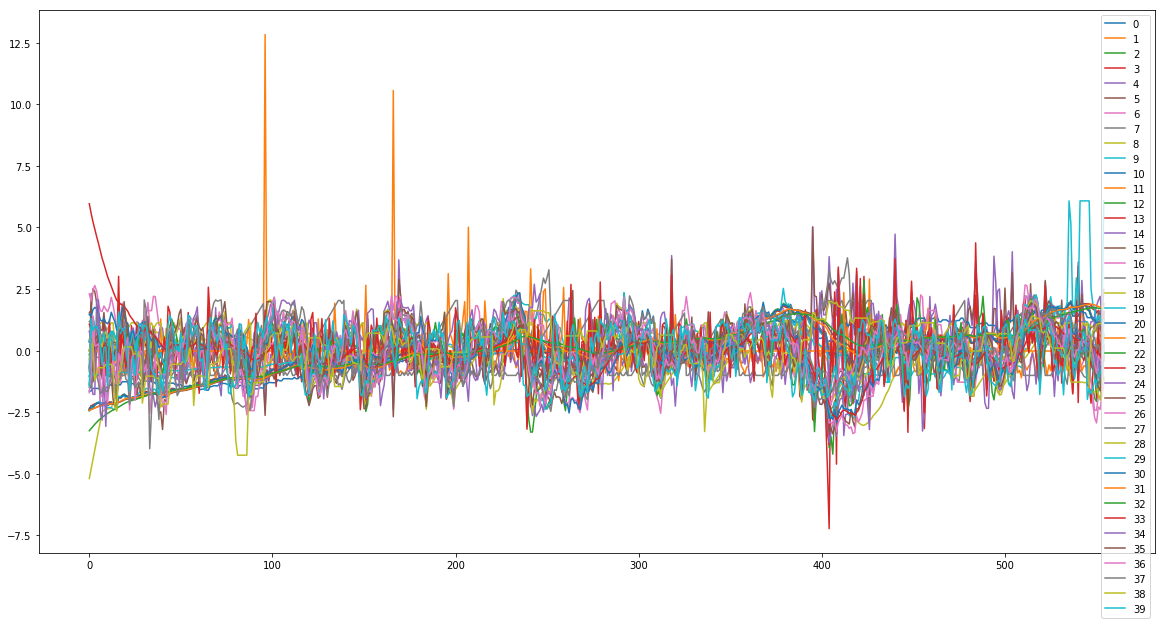

In [53]:
# observe trend in data in graph
df_std.plot(figsize=(20,10))

In [54]:
df_std.columns = cols
df_std.describe() #note that mean is 0 and std_dev is 1

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,...,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,6.245255e-16,-3.492702e-16,9.821973e-16,-5.961198e-17,-6.241254e-17,-1.240249e-16,-3.340671e-17,-1.052211e-16,1.950392e-17,-6.601326e-15,...,-1.002401e-15,-8.241656e-17,3.792762e-16,-1.358273e-16,-1.025206e-17,3.125628e-17,2.043410e-16,-1.158733e-16,-3.680739e-17,9.361881e-17
std,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,...,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00,1.000902e+00
min,-2.427219e+00,-2.402838e+00,-2.406055e+00,-2.341730e+00,-2.388481e+00,-2.717807e+00,-2.935333e+00,-2.293327e+00,-5.188950e+00,-2.707093e+00,...,-2.899269e+00,-2.426534e+00,-3.250430e+00,-2.800654e+00,-3.075982e+00,-3.201506e+00,-2.601265e+00,-3.982994e+00,-4.243958e+00,-1.978658e+00
25%,-6.498034e-01,-6.472202e-01,-6.296316e-01,-6.468103e-01,-7.069979e-01,-7.532217e-01,-6.609527e-01,-6.557920e-01,-1.529644e-01,-7.112023e-01,...,-6.177506e-01,-6.587239e-01,-5.842274e-01,-3.778022e-01,-6.702956e-01,-6.889720e-01,-7.704566e-01,-8.121390e-01,-5.551347e-01,-9.368667e-01
50%,1.130475e-01,1.160457e-01,1.058389e-01,9.497507e-02,-2.317145e-01,-1.882084e-01,6.354622e-02,-1.301817e-01,1.986252e-01,1.532521e-01,...,7.136980e-02,1.423421e-01,2.298732e-01,-2.647365e-02,-2.985061e-02,6.414822e-02,5.884453e-02,1.069757e-01,1.021687e-01,2.827960e-01
75%,6.149043e-01,6.192832e-01,6.161566e-01,5.952137e-01,4.854043e-01,5.266717e-01,7.111292e-01,5.614449e-01,5.676750e-01,7.202641e-01,...,7.191901e-01,5.681464e-01,5.996280e-01,3.466947e-01,7.412519e-01,7.505256e-01,7.577615e-01,6.311492e-01,6.429668e-01,8.534242e-01
max,2.023316e+00,1.957749e+00,1.959482e+00,1.903681e+00,5.026061e+00,5.012013e+00,2.666962e+00,3.765473e+00,1.542898e+00,2.020585e+00,...,2.326203e+00,1.889394e+00,1.740608e+00,5.962034e+00,2.052995e+00,1.987598e+00,2.171655e+00,2.058964e+00,1.999433e+00,1.578862e+00


In [55]:
# make time series data stationary in the mean, thus having no trend in the data
# applying log(Vt/Vt-1) on all data
df_std_log = np.log(abs(df_std[cols]/df_std[cols].shift()))

# remove first row (contains NaN because of the t-1 shift)
df_std_log = df_std_log.iloc[1:]
df_std_log.columns = data.columns
df_std_log.describe()


,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,30_day_RSI,EMA_12,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,5.540000e+02,554.000000
mean,-0.001310,-0.001044,-0.001157,-0.000374,0.001415,0.001131,0.000710,0.000096,-0.004690,-0.002269,...,-0.002504,-0.000551,-0.001141,-0.005819,-0.002777,-0.003383,-0.003322,-0.003672,1.902363e-03,-0.000283
std,0.517252,0.525585,0.551246,0.532237,1.275879,1.203841,1.014105,0.858766,0.639027,0.601686,...,0.873639,0.236827,0.183685,0.526104,1.087502,0.991830,0.969454,1.071884,7.656833e-01,1.182175
min,-4.450568,-3.869609,-4.979708,-3.869648,-7.376284,-4.460908,-3.615943,-5.587463,-5.828759,-4.027441,...,-5.258686,-1.690251,-1.587858,-3.105675,-7.967274,-4.760875,-5.214129,-8.414687,-4.044790e+00,-4.566508
25%,-0.107296,-0.076633,-0.100438,-0.101586,-0.551367,-0.580915,-0.511741,-0.300092,-0.099636,-0.011164,...,-0.242164,-0.030483,-0.024074,-0.132189,-0.341584,-0.376455,-0.344418,-0.245370,-3.685903e-02,-0.461072
50%,-0.002647,-0.002257,-0.001094,0.000255,0.000066,0.018476,-0.001904,0.047594,-0.008021,0.000000,...,0.013554,-0.002213,-0.002975,-0.018621,-0.004272,-0.016130,-0.017473,0.010055,2.159478e-07,-0.065281
75%,0.105674,0.087183,0.104580,0.120267,0.515716,0.560944,0.458670,0.303081,0.085453,0.000000,...,0.266820,0.040848,0.024829,0.130138,0.319337,0.331292,0.323325,0.279447,4.540951e-02,0.427545
max,2.723830,3.469542,4.264000,2.985000,7.316076,4.533647,4.574561,5.957292,5.451186,5.872856,...,5.971683,1.858497,1.761912,3.498382,6.991285,5.624477,5.532011,6.311823,5.116774e+00,5.079575


In [56]:
df_std_log['Down'] = 0
df_std_log['Up'] = 0
df_std_log.loc[df_std_log['Close'] >= 0, 'Up'] = 1
df_std_log.loc[df_std_log['Close'] < 0, 'Down'] = 1
#df_std = df_std_log
df_std_log.describe()

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI,Down,Up
count,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,...,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,5.540000e+02,554.000000,554.000000,554.000000
mean,-0.001310,-0.001044,-0.001157,-0.000374,0.001415,0.001131,0.000710,0.000096,-0.004690,-0.002269,...,-0.001141,-0.005819,-0.002777,-0.003383,-0.003322,-0.003672,1.902363e-03,-0.000283,0.487365,0.512635
std,0.517252,0.525585,0.551246,0.532237,1.275879,1.203841,1.014105,0.858766,0.639027,0.601686,...,0.183685,0.526104,1.087502,0.991830,0.969454,1.071884,7.656833e-01,1.182175,0.500292,0.500292
min,-4.450568,-3.869609,-4.979708,-3.869648,-7.376284,-4.460908,-3.615943,-5.587463,-5.828759,-4.027441,...,-1.587858,-3.105675,-7.967274,-4.760875,-5.214129,-8.414687,-4.044790e+00,-4.566508,0.000000,0.000000
25%,-0.107296,-0.076633,-0.100438,-0.101586,-0.551367,-0.580915,-0.511741,-0.300092,-0.099636,-0.011164,...,-0.024074,-0.132189,-0.341584,-0.376455,-0.344418,-0.245370,-3.685903e-02,-0.461072,0.000000,0.000000
50%,-0.002647,-0.002257,-0.001094,0.000255,0.000066,0.018476,-0.001904,0.047594,-0.008021,0.000000,...,-0.002975,-0.018621,-0.004272,-0.016130,-0.017473,0.010055,2.159478e-07,-0.065281,0.000000,1.000000
75%,0.105674,0.087183,0.104580,0.120267,0.515716,0.560944,0.458670,0.303081,0.085453,0.000000,...,0.024829,0.130138,0.319337,0.331292,0.323325,0.279447,4.540951e-02,0.427545,1.000000,1.000000
max,2.723830,3.469542,4.264000,2.985000,7.316076,4.533647,4.574561,5.957292,5.451186,5.872856,...,1.761912,3.498382,6.991285,5.624477,5.532011,6.311823,5.116774e+00,5.079575,1.000000,1.000000


In [57]:
df_std = df_std[1:]
df_std['Up'] = df_std_log['Up']
df_std['Down'] = df_std_log['Down']

In [58]:
df_std.index = range(0,len(df_std))


In [59]:
#Blasting the outliers
from scipy import stats
z = pd.DataFrame(abs(stats.zscore(df_std,axis = 1)))
z.columns = df_std.columns
df_std = df_std[(z < 3).all(axis=1)]

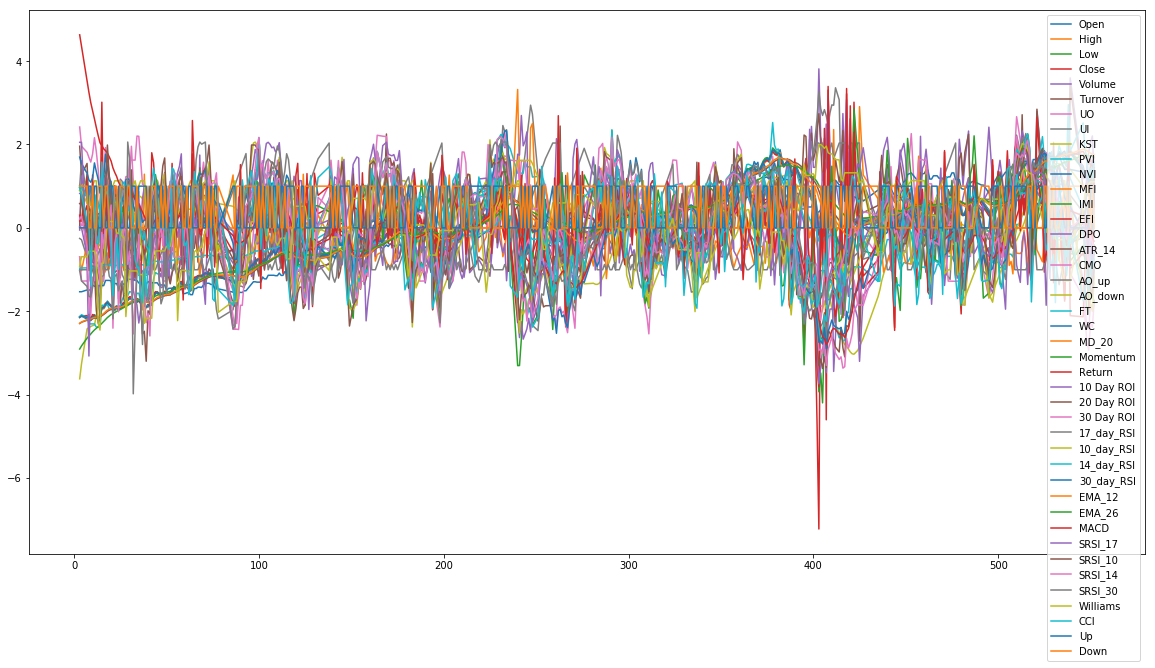

In [60]:
df_std.plot(figsize=(20,10))

In [61]:
df_std.head()

,Open,High,Low,Close,Volume,Turnover,UO,UI,KST,PVI,...,EMA_26,MACD,SRSI_17,SRSI_10,SRSI_14,SRSI_30,Williams,CCI,Up,Down
3,-2.152233,-2.151894,-2.137592,-2.131616,-0.053730,0.038479,0.261256,-0.254148,-3.622997,-2.129694,...,-2.908472,4.631670,2.052995,0.581452,0.209654,-1.032190,-0.922863,0.957402,0,1
4,-2.116824,-2.121519,-2.105345,-2.113836,1.347550,0.896425,0.047229,-0.287127,-3.260520,-2.085911,...,-2.833022,4.353441,2.052995,0.610931,0.282003,-1.272912,-0.694065,0.806208,0,1
7,-2.191068,-2.151823,-2.147208,-2.104946,-0.495940,-0.843185,0.141674,-0.706645,-2.425560,-2.145616,...,-2.647089,3.514985,-0.893675,-0.111482,-0.465348,-1.407253,-0.694065,0.123212,0,1
8,-2.079060,-2.106829,-2.174395,-2.169928,-0.357278,-0.752720,-0.918742,-0.891241,-2.390236,-2.305213,...,-2.594940,3.252388,-3.075982,0.331832,-1.807300,-1.645287,-0.561350,0.142461,1,0
9,-2.220908,-2.228043,-2.202882,-2.173032,-0.531580,-0.819814,-0.884928,-1.056708,-2.366829,-2.305213,...,-2.546871,3.002839,-1.157400,-0.226058,-2.087893,-1.659524,-0.561350,-1.401582,1,0


In [62]:
cols = df_std.columns
cols = cols[::-1]

In [63]:
dataset = df_std[cols]
dataset = dataset.astype(float)

In [64]:
dataset.columns[[0,1]]

Index(['Down', 'Up'], dtype='object')

In [65]:
class DataProvider():
    def __init__(self, dataset, batch_size):
        self.ctr = 0
        self.batch_size = batch_size
        
        # split training/testing according to ratio (default 0.8)
        train_set_size = int(len(dataset) * 0.8)
        test_set_size = len(dataset) - train_set_size

        self.training_dataset = dataset[:train_set_size]
        self.testing_dataset  = dataset[train_set_size:]

        # split labels
        self.training_labels = self.training_dataset[self.training_dataset.columns[:2]]
        self.training_dataset = self.training_dataset[self.training_dataset.columns[2:]]
        self.testing_labels = self.testing_dataset[self.testing_dataset.columns[:2]]
        self.testing_dataset = self.testing_dataset[self.testing_dataset.columns[2:]]
        
    def next_batch_train(self):
        begin_position = self.ctr * self.batch_size
        
        if begin_position + self.batch_size >= len(self.training_dataset):
            data = self.training_dataset[begin_position:]
            label = self.training_labels[begin_position:]
            self.ctr = 0
        else:
            data = self.training_dataset[begin_position:begin_position + self.batch_size]
            label = self.training_labels[begin_position:begin_position + self.batch_size]
            self.ctr += 1
        
        return data.values, label.values
    
    def get_test_data(self):
        return self.testing_dataset.values, self.testing_labels.values

# Step 3: Create Model

In [66]:
# config
no_of_iterations = 50000
batch_size = 200 #?

## model config
hidden_layer1_neurons = 60
hidden_layer2_neurons = 30
hidden_layer3_neurons = 20

# DropOut
pkeep_train = 0.75 #?

# number of features
input_dim = len(dataset.columns) - 2

# number of output classes
output_dim = 2

In [67]:
data_provider = DataProvider(dataset, batch_size)

In [68]:
# custom decorator for Model
#  - to make functions execute only the first time (every time the functions are called, the graph would be extended by new code)
#  - name the variable scope for TF visualization
def define_scope(function, scope=None):
    attribute = '_cache_' + function.__name__

    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

Model description:
Model consists of 3 hidden layers + 1 softmax output layer.
Incorporates shootout while training to make inidividual neurons more independent on other layers and perform better.
Incorporates learning rate decay.

In [69]:
class Model():
    def __init__(self, data, label, learning_rate):
        self.data = data
        self.label = label
        self.learning_rate = learning_rate
        self.prediction
        self.optimize
        
    @define_scope
    def prediction(self):        
        # weights + biases
        w1 = tf.Variable(tf.truncated_normal([input_dim, hidden_layer1_neurons], stddev=0.0001))
        b1 = tf.Variable(tf.ones([hidden_layer1_neurons]))

        w2 = tf.Variable(tf.truncated_normal([hidden_layer1_neurons, hidden_layer2_neurons], stddev=0.0001))
        b2 = tf.Variable(tf.ones([hidden_layer2_neurons]))

        w3 = tf.Variable(tf.truncated_normal([hidden_layer2_neurons, hidden_layer3_neurons], stddev=0.0001))
        b3 = tf.Variable(tf.ones([hidden_layer3_neurons]))
        
        w4 = tf.Variable(tf.truncated_normal([hidden_layer3_neurons, output_dim], stddev=0.0001))
        b4 = tf.Variable(tf.ones([output_dim]))
        
        # hidden layers
        Y1 = tf.nn.relu(tf.matmul(self.data, w1) + b1)
        Y1d = tf.nn.dropout(Y1, pkeep)
        Y2 = tf.nn.relu(tf.matmul(Y1, w2) + b2)
        Y2d = tf.nn.dropout(Y2, pkeep)
        Y3 = tf.nn.relu(tf.matmul(Y2, w3) + b3)
        Y3d = tf.nn.dropout(Y3, pkeep)
        
        # softmax layer
        return tf.nn.softmax(tf.matmul(Y3d, w4) + b4)
    
    @define_scope
    def optimize(self):
        # compute cost function and minimize
        cross_entropy = -tf.reduce_sum(self.label * tf.log(self.prediction))
        return tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy), cross_entropy
    
    @define_scope
    def error(self):
        mistakes = tf.equal(tf.argmax(self.label, 1), tf.argmax(self.prediction, 1))
        accuracy = tf.reduce_mean(tf.cast(mistakes, tf.float32))
        loss = -tf.reduce_sum(self.label * tf.log(self.prediction))
        return accuracy, loss

In [70]:
# data feed
X = tf.placeholder(tf.float32, [None, input_dim])
_Y = tf.placeholder(tf.float32, [None, output_dim])
learning_rate = tf.placeholder(tf.float32)

# DropOut: feed in 1 when testing, 0.75 when training
pkeep = tf.placeholder(tf.float32)

In [71]:
model = Model(data=X, label=_Y, learning_rate=learning_rate)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [72]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

accuracy = []
_loss = []
for i in range(no_of_iterations):
    # execute training step
    # optimizer learning rate decay
    lrmax = 0.001
    lrmin = 0.00001
    lr = lrmin + (lrmax - lrmin) * math.exp(-i / 2000)
    
    data_batch, label_batch = data_provider.next_batch_train()
    sess.run(model.optimize, feed_dict={X: data_batch, _Y: label_batch, learning_rate:lr, pkeep: pkeep_train})
    
    if i % 500 == 0:
        # compute accuracy
        data_batch, label_batch = data_provider.get_test_data()
        acc, loss = sess.run(model.error, feed_dict={X: data_batch, _Y: label_batch, pkeep: 1})
        accuracy.append(acc)
        _loss.append(loss)
        print('---epoch {}---\naccuracy: {}, loss: {}'.format(i // 500, acc, loss))

print('Training finished')

---epoch 0---
accuracy: 0.40449437499046326, loss: 62.07009506225586
---epoch 1---
accuracy: 0.5955055952072144, loss: 60.22622299194336
---epoch 2---
accuracy: 0.5955055952072144, loss: 60.34910202026367
---epoch 3---
accuracy: 0.5955055952072144, loss: 60.38013458251953
---epoch 4---
accuracy: 0.5955055952072144, loss: 60.438720703125
---epoch 5---
accuracy: 0.5955055952072144, loss: 60.45198440551758
---epoch 6---
accuracy: 0.5955055952072144, loss: 60.46266555786133
---epoch 7---
accuracy: 0.5955055952072144, loss: 60.45657730102539
---epoch 8---
accuracy: 0.5955055952072144, loss: 60.4461555480957
---epoch 9---
accuracy: 0.5955055952072144, loss: 60.44660186767578
---epoch 10---
accuracy: 0.5955055952072144, loss: 60.451454162597656
---epoch 11---
accuracy: 0.5955055952072144, loss: 60.46175003051758
---epoch 12---
accuracy: 0.5955055952072144, loss: 60.463375091552734
---epoch 13---
accuracy: 0.5955055952072144, loss: 60.464500427246094
---epoch 14---
accuracy: 0.5955055952072144

In [73]:
# accuracy on test data
data_batch, label_batch = data_provider.get_test_data()
acc, loss = sess.run(model.error, feed_dict={X: data_batch, _Y: label_batch, pkeep: 1})
print('Test: accuracy={}, loss={}'.format(acc, loss))

Test: accuracy=0.5955055952072144, loss=60.46434783935547


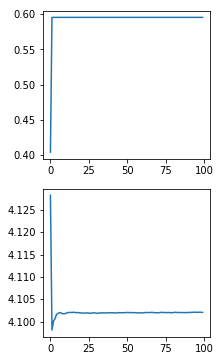

In [74]:
plt.figure(figsize=(3,6))

# accuracy
plt.subplot(211)
plt.plot(accuracy)

# loss
plt.subplot(212)
plt.plot(np.log(_loss))

plt.show()